In [1]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt

from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from sklearn.covariance import GraphicalLasso

import torch
from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data

import hypernetx as hnx
import hypernetx.algorithms.hypergraph_modularity as hmod
import networkx as nx
from networkx.convert_matrix import from_numpy_array

import functions as f
from functions import dict_to_array, normalize_array

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Loading atlas, time series and threshold
_, _, atlas_labels, n_ROIs = f.gen_atlas_labels()

In [3]:
# Loading the time series
time_series_list = f.load_time_series()
time_series_df_list = f.list_of_df_of_time_series(time_series_list)
# time_series_list[0]
# time_series_df_list[0]

In [4]:
# Loading the pearson correlation matrices
corr_matrix_list = f.corr_matrix_paths()['pearson']
print(corr_matrix_list)

['patient_136_S_4517.csv', 'patient_130_S_4468.csv', 'patient_002_S_4654.csv', 'patient_002_S_4251.csv', 'patient_013_S_5171.csv', 'patient_130_S_2391.csv', 'patient_031_S_4947.csv', 'patient_100_S_5102.csv', 'patient_012_S_5121.csv', 'patient_053_S_5287.csv', 'patient_002_S_1261.csv', 'patient_018_S_4313.csv', 'patient_130_S_4641.csv', 'patient_012_S_4188.csv', 'patient_002_S_4521.csv', 'patient_130_S_4250.csv', 'patient_031_S_4005.csv', 'patient_130_S_5006.csv', 'patient_006_S_4363.csv', 'patient_012_S_4012.csv', 'patient_031_S_4149.csv', 'patient_031_S_4029.csv', 'patient_013_S_4917.csv', 'patient_129_S_4287.csv', 'patient_130_S_4730.csv', 'patient_129_S_0778.csv', 'patient_031_S_4203.csv', 'patient_013_S_4268.csv', 'patient_053_S_0919.csv', 'patient_002_S_4447.csv', 'patient_012_S_4987.csv', 'patient_018_S_4868.csv', 'patient_100_S_4556.csv', 'patient_100_S_5106.csv', 'patient_130_S_5175.csv', 'patient_130_S_4294.csv', 'patient_053_S_5296.csv', 'patient_031_S_4474.csv', 'patient_12

In [5]:
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[0]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
print(corr_matrix_patient)

[[ 1.          0.62126391  0.40501965 ... -0.07884583  0.07740484
  -0.36456412]
 [ 0.62126391  1.         -0.0033939  ...  0.02684759  0.0412815
  -0.1746839 ]
 [ 0.40501965 -0.0033939   1.         ... -0.17088309 -0.15494682
  -0.09877457]
 ...
 [-0.07884583  0.02684759 -0.17088309 ...  1.          0.39632277
   0.00382471]
 [ 0.07740484  0.0412815  -0.15494682 ...  0.39632277  1.
   0.35172939]
 [-0.36456412 -0.1746839  -0.09877457 ...  0.00382471  0.35172939
   1.        ]]


In [7]:
def display_hypergraph(hypergraph):
    # Displaying the hypergraph
    n_nodes = len(hypergraph.nodes)
    n_edges = len(hypergraph.edges)
    print("Hypergraph number of nodes:", n_nodes)
    print("Hypergraph number of edges:", n_edges)
    print(hypergraph.shape)

    plt.subplots(figsize=(10,10))
    hnx.draw(hypergraph, with_edge_labels=False)
    plt.show()

## Visualization of some Hypergraphs built from various method implementations

In [24]:
def remove_duplicate_hyperedges(hypergraph_dict):
    unique_hyperedges = {}
    for hyperedge, vertices in hypergraph_dict.items():
        print(hyperedge, vertices)
        sorted_vertices = sorted(vertices)
        sorted_vertices_tuple = tuple(sorted_vertices)
        if sorted_vertices_tuple not in unique_hyperedges.values():
            unique_hyperedges[hyperedge] = sorted_vertices_tuple
    # print("Dictionary representation of the hypergraph:")
    # print(unique_hyperedges)
    return unique_hyperedges

### Fourier Clustering Method

In [21]:
# Using the Fourier Clustering Method

n_patient = 0
threshold = 0.4

def adjacency_matrix_to_hypergraph_dict(adjacency_matrix):
    hypergraph_dict = {}
    for i, row in enumerate(adjacency_matrix):
        hyperedge = []
        for j, val in enumerate(row):
            if val == 1:
                hyperedge.append(j)
        hypergraph_dict[i] = hyperedge
    return hypergraph_dict

def generate_adjacency_from_cluster_indices(cluster_indices):
    n_ROIs = len(cluster_indices)
    adjacency = np.zeros((n_ROIs, n_ROIs))
    for row_idx in range(n_ROIs):
        for col_idx in range(n_ROIs):
            if cluster_indices[row_idx] == cluster_indices[col_idx]:
                adjacency[row_idx, col_idx] = 1
    return adjacency

def generate_hypergraph_from_cluster(correlation_matrix, threshold, display=False):
    # Transforming correlation matrix into dissimilarity matrix
    dissimilarity_matrix = 1 - np.abs(correlation_matrix)
    dissimilarity_matrix[np.isnan(dissimilarity_matrix)] = 0
    # Performing Fourier clustering
    linkage_matrix = linkage(squareform(dissimilarity_matrix), method='complete')
    cluster_indices = fcluster(linkage_matrix, threshold, criterion='distance')
    # Generating hypergraph from the cluster indices
    adjacency = generate_adjacency_from_cluster_indices(cluster_indices)
    hg_dict = adjacency_matrix_to_hypergraph_dict(adjacency)
    # Reducing the amount of hyperedges by removing duplicated hyperedges
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    # Creating HyperNetX hypergraph
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating HyperNetX hypergraph from clustering method
path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[n_patient]}'
corr_matrix_patient = np.loadtxt(path, delimiter=',')
h, hg_dict = generate_hypergraph_from_cluster(corr_matrix_patient, threshold)

0 [0]
1 [1, 57]
2 [2, 6]
3 [3]
4 [4]
5 [5, 25, 76, 77]
6 [2, 6]
7 [7, 61]
8 [8, 14]
9 [9, 15]
10 [10, 12]
11 [11, 13]
12 [10, 12]
13 [11, 13]
14 [8, 14]
15 [9, 15]
16 [16, 17, 78]
17 [16, 17, 78]
18 [18, 19]
19 [18, 19]
20 [20, 21, 82, 83, 108]
21 [20, 21, 82, 83, 108]
22 [22, 23]
23 [22, 23]
24 [24]
25 [5, 25, 76, 77]
26 [26, 27]
27 [26, 27]
28 [28, 62, 63]
29 [29]
30 [30]
31 [31]
32 [32, 33]
33 [32, 33]
34 [34, 35]
35 [34, 35]
36 [36, 37, 38, 39]
37 [36, 37, 38, 39]
38 [36, 37, 38, 39]
39 [36, 37, 38, 39]
40 [40, 41]
41 [40, 41]
42 [42, 43, 46, 47]
43 [42, 43, 46, 47]
44 [44, 45, 48, 49]
45 [44, 45, 48, 49]
46 [42, 43, 46, 47]
47 [42, 43, 46, 47]
48 [44, 45, 48, 49]
49 [44, 45, 48, 49]
50 [50, 51]
51 [50, 51]
52 [52, 53, 86, 87]
53 [52, 53, 86, 87]
54 [54]
55 [55]
56 [56, 68, 69]
57 [1, 57]
58 [58, 59]
59 [58, 59]
60 [60]
61 [7, 61]
62 [28, 62, 63]
63 [28, 62, 63]
64 [64]
65 [65, 66, 67]
66 [65, 66, 67]
67 [65, 66, 67]
68 [56, 68, 69]
69 [56, 68, 69]
70 [70, 71]
71 [70, 71]
72 [72, 7

/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

# Maximal Cliques Method

In [9]:
def max_cliques(graph):
    cliques = list(nx.find_cliques(graph))
    max_clique_nbr = max(len(c) for c in cliques)
    summ = sum(1 for c in cliques)
    print(f"Number of cliques: {summ}")
    return cliques, max_clique_nbr

def graph_to_hypergraph_max_cliques(graph, display=False):
    cliques, max_clique_nbr = max_cliques(graph)
    hg_dict = {i: set(clique) for i, clique in enumerate(cliques) if len(clique) == max_clique_nbr}
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating an example HyperNetX hypergraph from max cliques method
threshold = 0.4
weight = False
age = False
sex = False
matrixprofile = True
method = 'pearson'

root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MP{matrixprofile}'
dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method, weight=weight, age=age, sex=sex, matrixprofile=matrixprofile)
f.dataset_features_and_stats(dataset)
graph = f.r2g_to_nx(dataset[0])

hg, hg_dict = graph_to_hypergraph_max_cliques(graph)



Dataset: Raw_to_Graph(197):
Number of graphs: 197
Weighted: False
Threshold: 0.4
Correlation Method: pearson
Number of features: 461
Number of classes: 6

Data(edge_index=[2, 1410], weight=[1410], x=[116, 461], y=[1], num_nodes=116)
Number of nodes: 116
Number of edges: 1410
Average node degree: 12.16
Has isolated nodes: True
Has self-loops: True
Is undirected: True
Number of cliques: 242


/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

# Coskewness Correlation Method

In [17]:
# Computing the coskewness matrix

def coskew(df):
    num = len(df.columns)
    coskew_matrix = [[[0 for k in range(num)] for j in range(num)] for i in range(num)]
    for i in range(num):
        v1 = [val for val in df[i]]
        meanv1 = np.mean(v1)
        std1 = np.std(v1)
        for j in range(num):
            v2 = [val for val in df[j]]
            meanv2 = np.mean(v2)
            std2 = np.std(v2)
            for k in range(num):
                v3 = [val for val in df[k]]
                meanv3 = np.mean(v3)
                std3 = np.std(v3)
                coskew_matrix[i][j][k] = (np.mean((v1[i]-meanv1)*(v2[j]-meanv2)*(v3[k]-meanv3)))/(std1*std2*std3)
    
    ### Idk if it is necessary to normalize the results
    # Normalize the results
    max_abs_val = np.max(np.abs(coskew_matrix))
    coskew_matrix_normalized = [[[val / max_abs_val for val in range(num)] for j in range(num)] for i in range(num)]
    
    return coskew_matrix_normalized

coskew_matrix = coskew(time_series_df_list[0])
print(len(coskew_matrix))
print(len(coskew_matrix[0]))
print(len(coskew_matrix[0][0]))
print(coskew_matrix[0][0][0])

116
116
116
0.0


In [12]:
print(max(max(max(coskew_matrix))))
print(min(min(min(coskew_matrix)))) 

2.273788338421976
0.0


In [13]:
# Saving all the Coskewness Matrices
### Need to change this function to save the coskewness matrices in the correct format (i.e. here we have a 3D object??)
def save_coskew_matrices(coskew_matrices_list):
    directory = f'ADNI_full/coskew_matrices/'
    patient_info = pd.read_csv('ADNI_full/patient_info.csv')
    os.makedirs(directory, exist_ok=True)
    for idx_patient, name_patient in enumerate(patient_info['Subject ID'].values):
        np.savetxt(f'{directory}patient_{name_patient}.csv', coskew_matrices_list[idx_patient], delimiter=',')
    return None

In [15]:
# Computing and saving the coskewness matrices
coskew_matrices_list = []
for i, time_series_df in enumerate(time_series_df_list):
    coskew_matrix = coskew(time_series_df)
    coskew_matrices_list.append(coskew_matrix)
    print('Done Processing patient nbr', i)
save_coskew_matrices(coskew_matrices_list)

KeyboardInterrupt: 

0 [115, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
1 [115, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115]
2 [115, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 

/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:150: DeprecationWarning: misc_props_col and misc_cell_props_col will be deprecated; all public references to these arguments will be removed in a future release.
  warnings.warn(
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/hypergraph.py:563: FutureWarning: This method or function will be deprecated in a future release. Public references to this method or function will be removed from the Hypergraph API in a future release.
  self._nodes = self.E.restrict_to_levels([1])
/Users/mathilde/anaconda3/envs/alzheimers-cl/lib/python3.11/site-packages/hypernetx/classes/entityset.py:618: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  elements = self._datafram

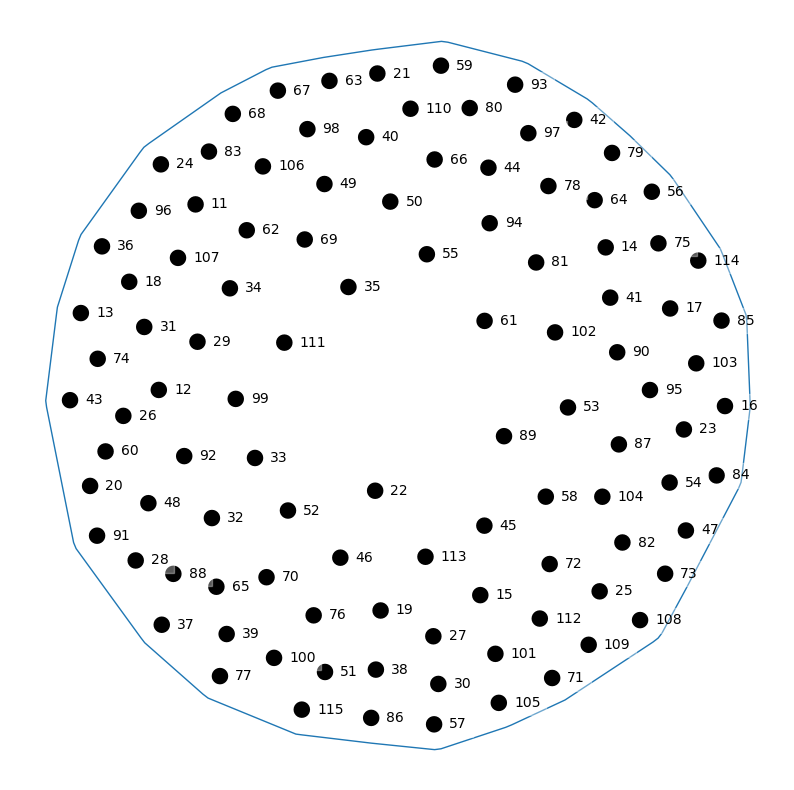

In [18]:
# Building a hypergraph from a coskewness matrix
def adjacency_cube_to_hypergraph_dict(adjacency_cube):
    hg_dict = {}
    for i, row in enumerate(adjacency_cube):
        for j in range(len(row)):
            hyperedge = []
            for k, val in enumerate(row[j]):
                if val == 1:
                    if j not in hyperedge:
                        hyperedge.append(j)
                    hyperedge.append(k)
        hg_dict[i] = hyperedge
    return hg_dict

def coskewness_matrix_to_hypergraph(coskewness_matrix, threshold, display=False):
    adjacency_cube = np.zeros_like(coskewness_matrix)
    for i in range(len(coskewness_matrix)):
        for j in range(len(coskewness_matrix[i])):
            for k in range(len(coskewness_matrix[i][j])):
                if np.abs(coskewness_matrix[i][j][k]) > threshold:
                    adjacency_cube[i][j][k] = 1
    hg_dict = adjacency_cube_to_hypergraph_dict(adjacency_cube)
    hg_dict = remove_duplicate_hyperedges(hg_dict)
    hg = hnx.Hypergraph(hg_dict)
    if display:
        display_hypergraph(hg)
    return hg, hg_dict

# Creating an example HyperNetX hypergraph from coskewness matrix
threshold = 0.2
# coskewness_matrix = coskew_matrices_list[0]
coskewness_matrix = coskew_matrix
hg, hg_dict = coskewness_matrix_to_hypergraph(coskewness_matrix, threshold)

# Saving the Hypergraphs for all three methods

In [8]:
# Defining a function to save hypergraphs
def save_hypergraph(hg_dict, directory, method, threshold, id):
    dir = f'{directory}/{method}/thresh_{threshold}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    with open(f'{dir}/{id}_{method}_{threshold}.pkl', 'wb') as f:
        pkl.dump(hg_dict, f)
    return

In [2]:
time_series_folder = 'ADNI_full/time_series'
threshold = 0.4

for i, file_name in enumerate(os.listdir(time_series_folder)):
    patient_id = file_name[3:13]
    print(f'Processing patient {patient_id}')
    # for method in ['fourier_cluster', 'maximal_clique', 'coskewness']:
    for method in ['maximal_clique']:
        if method == 'fourier_cluster':
            path = f'ADNI_full/corr_matrices/corr_matrix_pearson/{corr_matrix_list[i]}'
            corr_matrix_patient = np.loadtxt(path, delimiter=',')
            _, hg_dict = generate_hypergraph_from_cluster(corr_matrix_patient, threshold=threshold)
        elif method == 'maximal_clique':
            method_corr = 'pearson'
            root = f'Raw_to_graph/ADNI_T_{threshold}_M_{method_corr}_WFalse_AFalse_SFalse_MPTrue'
            dataset = f.Raw_to_Graph(root=root, threshold=threshold, method=method_corr, weight=False, age=False, sex=False, matrixprofile=True)
            graph = f.r2g_to_nx(dataset[0])
            _, hg_dict = graph_to_hypergraph_max_cliques(graph)
        elif method == 'coskewness':
            coskewness_matrix_paths = f.coskewness_matrix_paths()
            coskewness_matrices = f.load_matrix(coskewness_matrix_paths)
            _, hg_dict = coskewness_matrix_to_hypergraph(coskewness_matrices[i], threshold=threshold)
        save_hypergraph(hg_dict, 'Hypergraphs', method, threshold, patient_id)
        print(f'Patient {patient_id} processed and saved for the {method} method with threshold {threshold}')

Processing patient 130_S_4883


NameError: name 'graph_to_hypergraph_max_cliques' is not defined

# Building the Raw_to_Hypergraph class

In [20]:
# Defining a class to preprocess raw data into a format suitable for training Graph Neural Networks (GNNs).
## With the possibility of assigning weight to edges, adding the age feature, sex feature, and matrixe profiling.

class Raw_to_Hypergraph(InMemoryDataset):
    def __init__(self, root, hg_data_path, method, weight, threshold, age=False, sex=False, transform=None, pre_transform=None):
        self.method = method
        self.weight = weight
        self.threshold = threshold
        self.age = age
        self.sex = sex
        self.hg_data_path = hg_data_path
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def processed_file_names(self):
        return ['data.pt']

    # This function is used to process the raw data into a format suitable for GNNs, by constructing graphs out of the connectivity matrices.
    def process(self):
        # Loading the prebuilt hypergraphs and the correlation matrices
        hg_dict_list = f.load_hg_dict(self.hg_data_path)
        print(hg_dict_list)
        full_corr_path_lists = f.corr_matrix_paths()
        corr_matrix_list = full_corr_path_lists['pearson']

        # Generating the diagnostic file from the diagnostic_label.csv file
        diagnostic_label = np.loadtxt('ADNI_full/diagnostic_label.csv', dtype=str, delimiter=',')
        # Combining the 'EMCI', 'LMCI' and 'MCI' diagnostics into a single 'MCI' label for simplicity, then one-hot encoding the diagnostics
        diagnostic_label = f.combine_diag_labels(diagnostic_label)

        graphs=[]
        for patient_idx, patient_hg in enumerate(hg_dict_list):
            print(patient_hg)
            # Create a NetworkX graph from the hypergraph matrix
            hypergraph = hnx.Hypergraph(patient_hg)

            # Adding the matrix profiling features to the feature array
            patient_matrix = corr_matrix_list[patient_idx]
            path = f'ADNI_full/matrix_profiles/matrix_profile_pearson/{patient_matrix}'
            with open(path, "rb") as fl:
                patient_dict = pkl.load(fl)
            # combine dimensions
            features = np.array(patient_dict['mp']).reshape(len(patient_dict['mp']),-1)
            features = features.astype(np.float32)

            # Loading the atlas, atlas labels and nbr_ROIS
            _, _, _, nbr_ROIs = f.gen_atlas_labels()    
            if self.age:
                # Loading the age feature of patients to use as a node feature
                ages = np.loadtxt('ADNI_full/age.csv', delimiter=',')
                min_age = np.min(ages)
                max_age = np.max(ages)
                # Extracting the age feature of the patient
                patient_age = ages[patient_idx]
                age_norm = (patient_age - min_age) / (max_age - min_age)
                # Making the age array the same size as the other arrays
                age_array = np.full((nbr_ROIs,), age_norm)
                features = np.concatenate((features, age_array), axis=-1)
            if self.sex:
                # Prepocessing the sex feature of patients to use as a node feature. Here, 0 represents male patients and 1 represents female patients
                sex = np.loadtxt('ADNI_full/sex.csv', dtype=str, delimiter=',')
                for patient in range(len(sex)):
                    if sex[patient] == 'M':
                        sex[patient] = 0
                    else:
                        sex[patient] = 1
                # Extracting the sex feature of the patient
                patient_sex = int(sex[patient_idx])
                # Making the sex array the same size as the other arrays
                sex_array = np.full((nbr_ROIs,), patient_sex)
                features = np.concatenate((features, sex_array), axis=-1)

            # Concatenate the degree, participation coefficient, betweenness centrality, local efficiency, and ratio of local to global efficiency arrays to form a single feature vector
            x = torch.tensor(features, dtype=torch.float)

            # Create a Pytorch Geometric Data object
            edge_index = []
            for edge in hypergraph.edges:
                edge_index.append([edge])
            y = torch.tensor(float(diagnostic_label[patient_idx]))
            hg_data = Data(x=x, edge_index=torch.tensor(edge_index, dtype=torch.long).t().contiguous(), y=y)
            graphs.append(hg_data)

        data, slices = self.collate(graphs)
        torch.save((data, slices), self.processed_paths[0])

In [22]:
# Testing the class Raw_to_Hypergraph with one example and saving it
threshold = 0.4
age = False
sex = False
method = 'maximal_clique'
if method == 'coskewness':
    weight = True
else:
    weight = False

hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'

root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
dataset = Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)

In [23]:
# Testing the class Raw_to_Graph with different thresholds, weights and methods and saving it
thresholds = [0.4, 0.5, 0.6]
age = False
sex = False
# methods = ['fourier_cluster', 'maximal_clique', 'coskewness']
methods = ['maximal_clique']
if method == 'coskewness':
    weight = True
else:
    weight = False

for method in methods:
    for threshold in thresholds:
        hg_data_path = f'Hypergraphs/{method}/thresh_{threshold}'
        root = f'Raw_to_hypergraph/ADNI_T_{threshold}_M_{method}_W{weight}_A{age}_S{sex}_MPTrue'
        dataset = Raw_to_Hypergraph(root=root, hg_data_path=hg_data_path, method=method, weight=weight, threshold=threshold, age=age, sex=sex)